In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from bmadx.plot import plot_projections
from bmadx.pmd_utils import openpmd_to_bmadx_beam, bmadx_beam_to_openpmd
from phase_space_reconstruction.analysis import screen_stats, get_beam_fraction_bmadx_beam, get_beam_fraction_bmadx_particle

In [2]:
data_dir = os.path.join('data', 'non_gaussian_beam')
t_scan_dir = os.path.join(data_dir, 't_scan')
n_par_dir = os.path.join(data_dir, 'n_par')

# Number of particles study

In [3]:
# ground truth beam:
gt =  torch.load(os.path.join(n_par_dir, 'non_gaussian_beam.pt')).numpy_particles()
# reconstructions:
r_1e4 = torch.load(os.path.join(n_par_dir, '3D_scan_10_000.pt')).numpy_particles()
r_1e5 = torch.load(os.path.join(n_par_dir, '3D_scan_100_000.pt')).numpy_particles()
r_1e6 = torch.load(os.path.join(n_par_dir, '3D_scan_1_000_000.pt')).numpy_particles()
np.shape(np.stack(gt[:6]))

(6, 1000000)

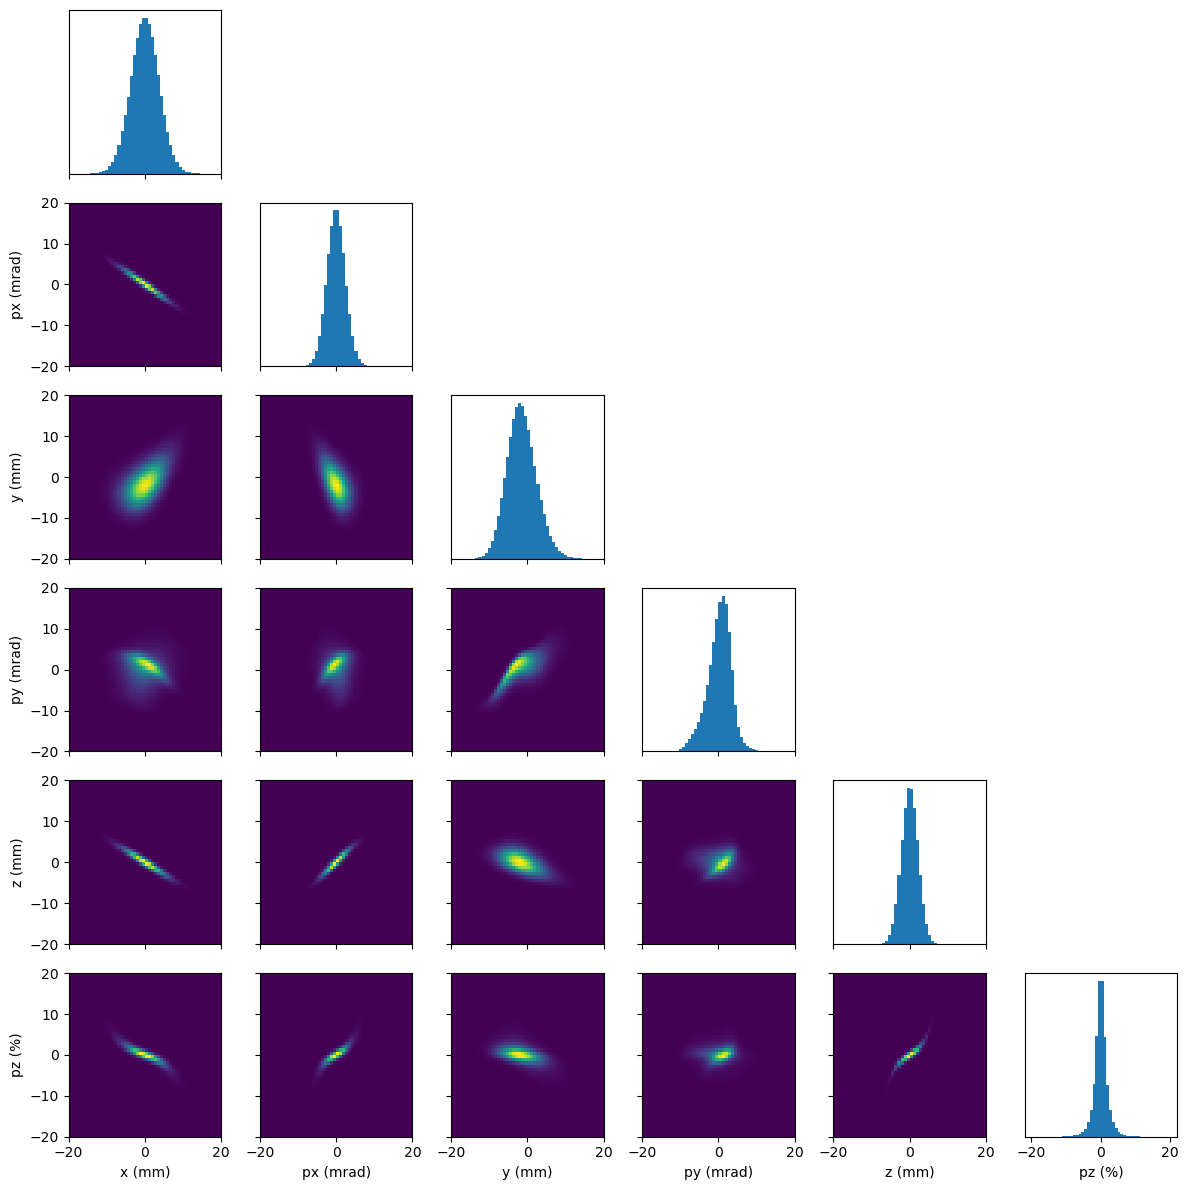

In [4]:
# plot gt:
lims = np.array([
    [-20e-3,20e-3],
    [-20e-3,20e-3],
    [-20e-3,20e-3],
    [-20e-3,20e-3],
    [-20e-3,20e-3],
    [-20e-2,20e-2]
])
plot_projections(gt, custom_lims=lims)
plt.show()

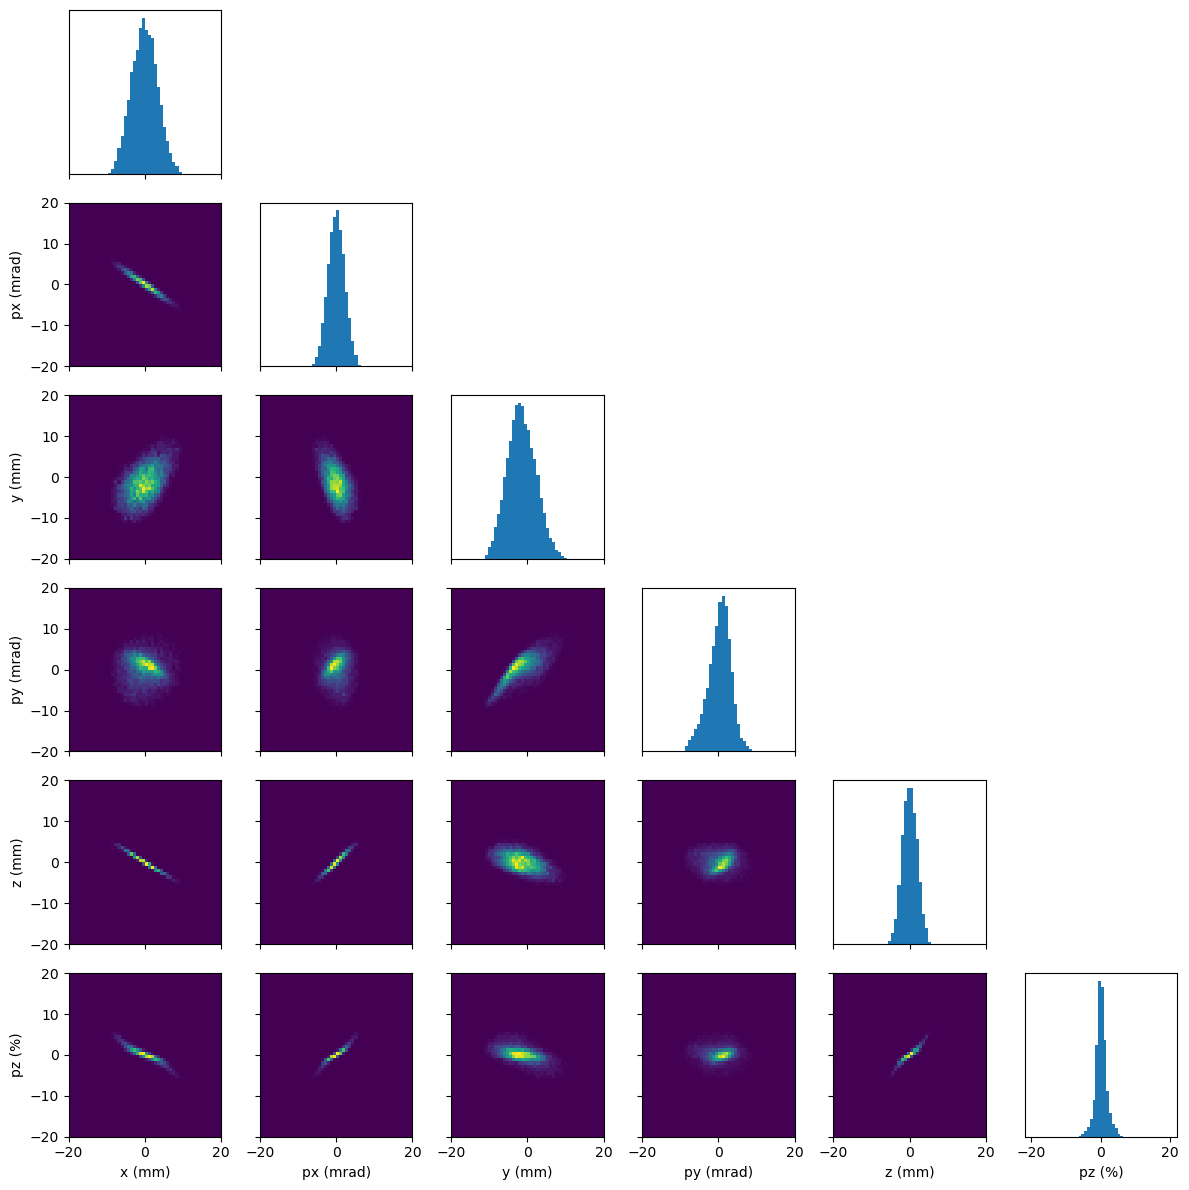

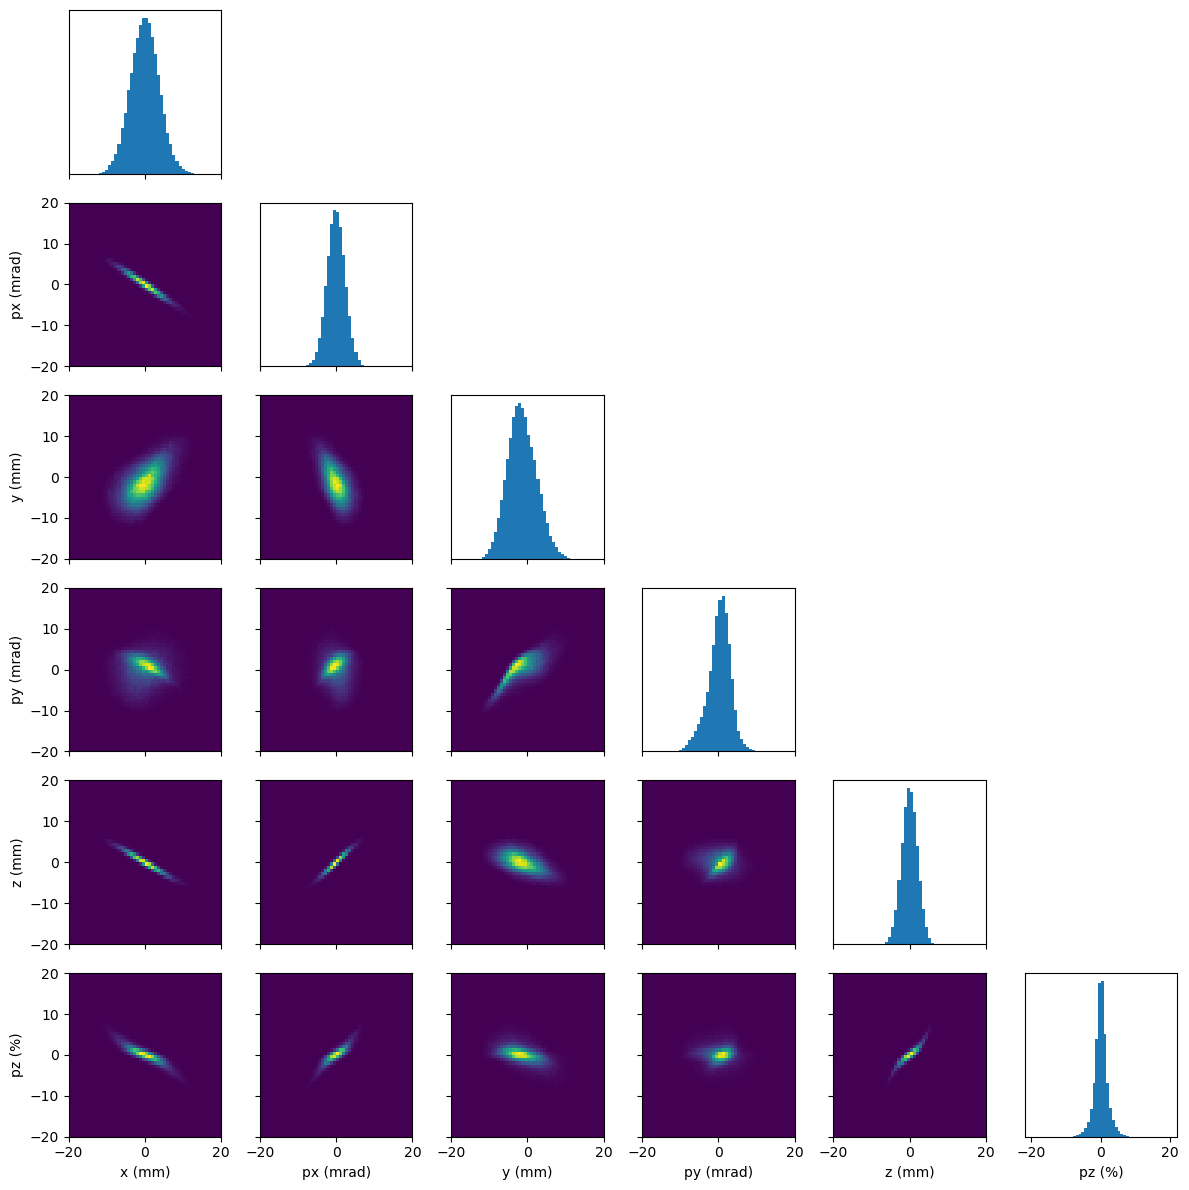

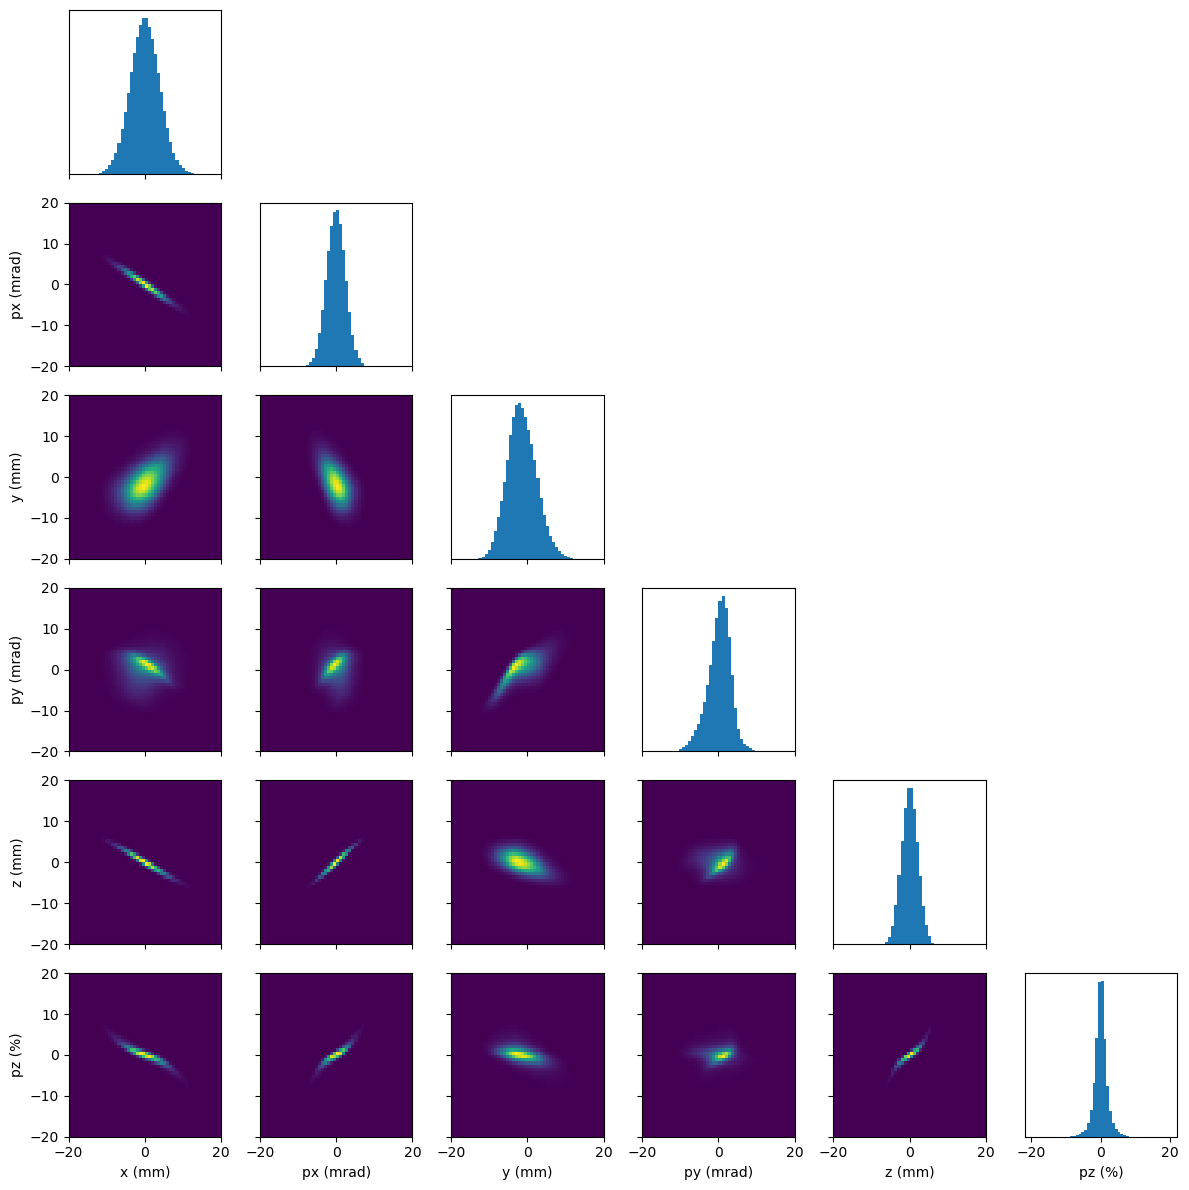

In [5]:
# plot recontructions:
plot_projections(r_1e4, custom_lims=lims)
plt.show()
plot_projections(r_1e5, custom_lims=lims)
plt.show()
plot_projections(r_1e6, custom_lims=lims)
plt.show()

In [6]:
#gt_frac_50 = get_beam_fraction_from_projection(gt, ('y','py'),0.5)
gt_frac_50 = get_beam_fraction_bmadx_particle(gt, 0.5)
gt_frac_90 = get_beam_fraction_bmadx_particle(gt, 0.9)
gt_frac_95 = get_beam_fraction_bmadx_particle(gt, 0.95)
print(len(gt_frac_50.x))
print(len(gt_frac_90.x))
print(len(gt_frac_95.x))

500000
900000
950000


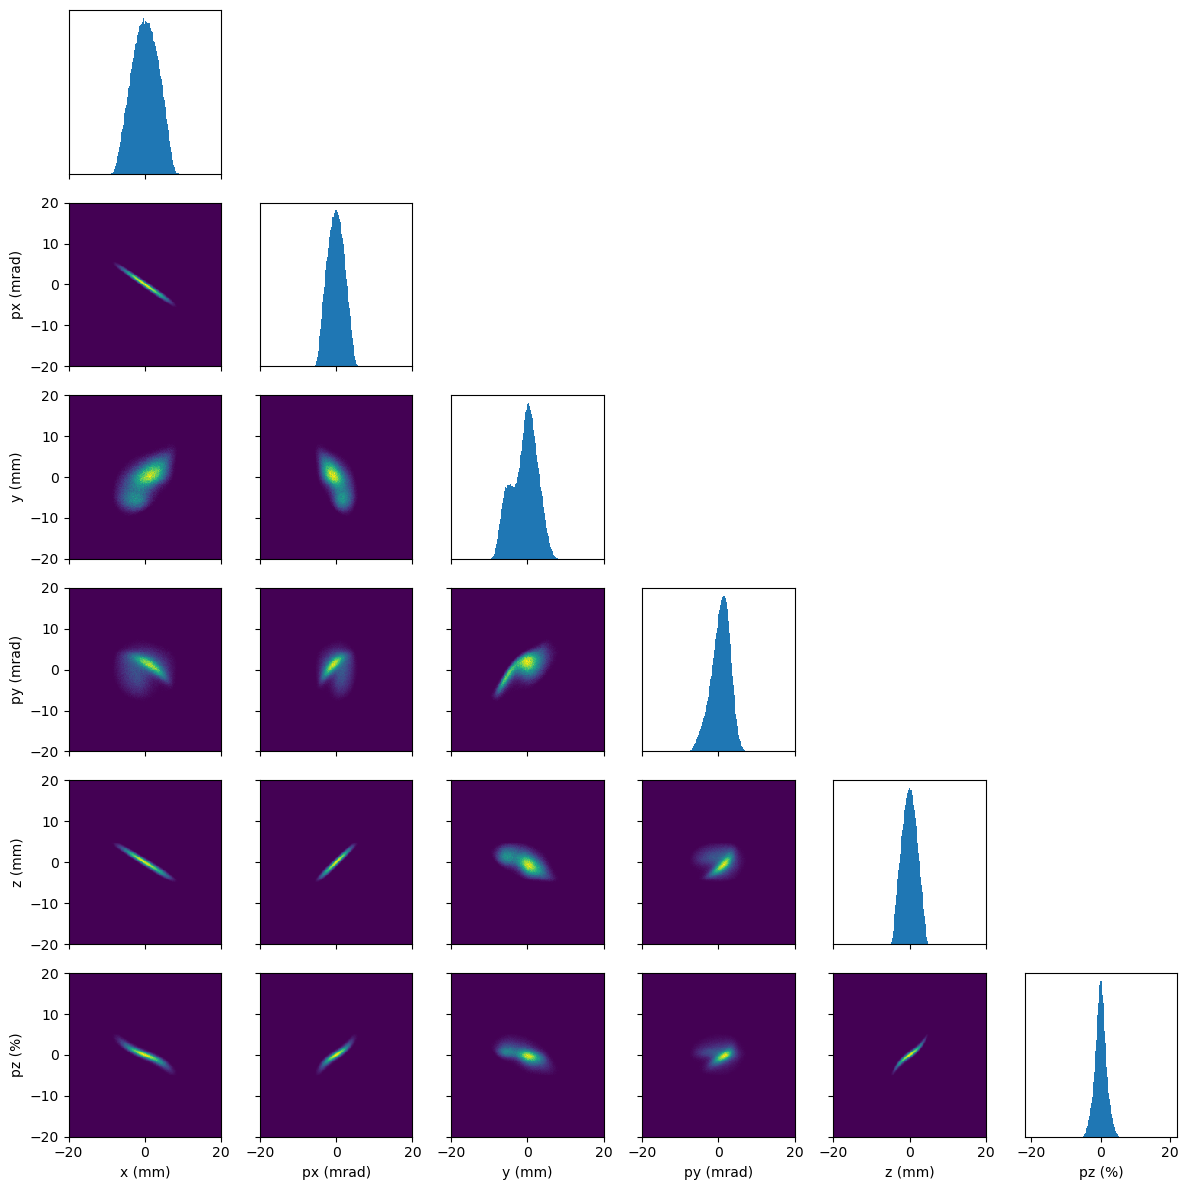

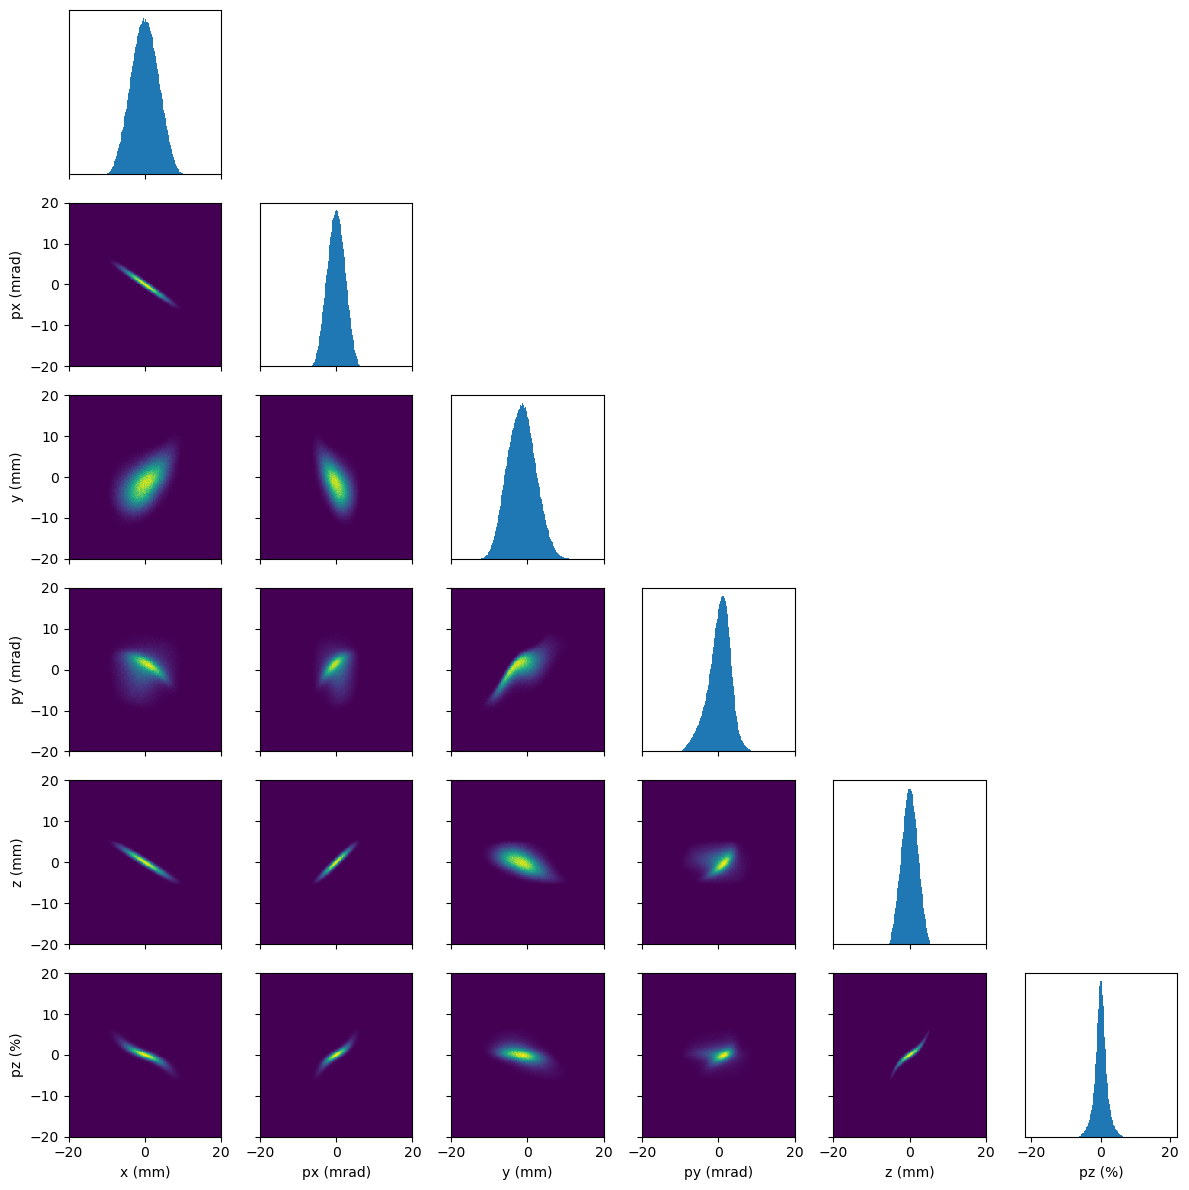

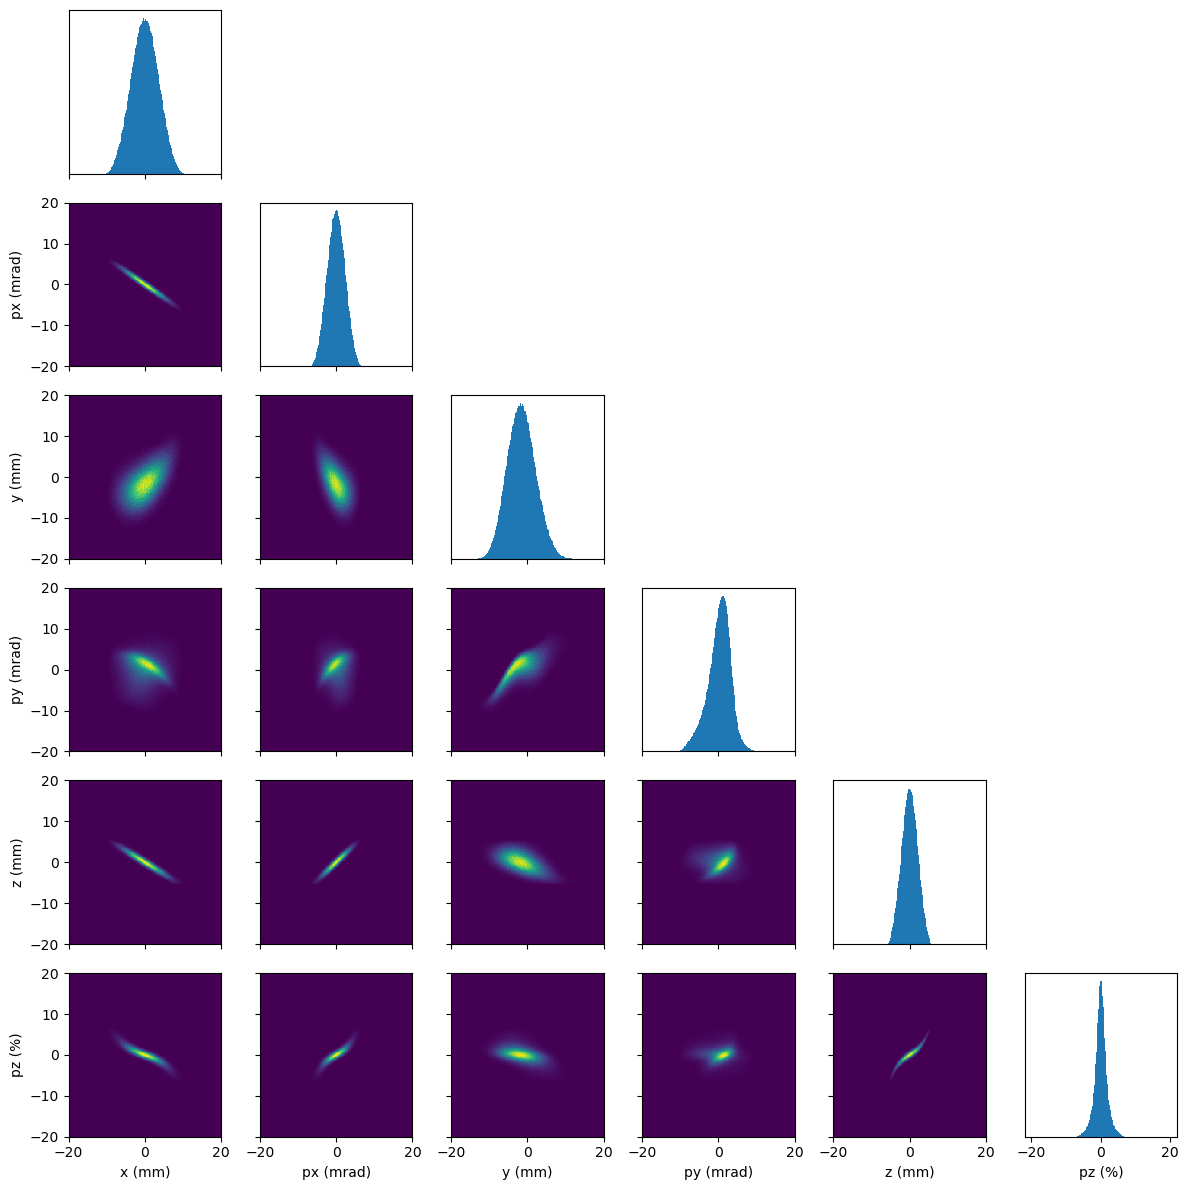

In [7]:
plot_projections(gt_frac_50, custom_lims=lims, bins=200)
plt.show()
plot_projections(gt_frac_90, custom_lims=lims, bins=200)
plt.show()
plot_projections(gt_frac_95, custom_lims=lims, bins=200)
plt.show()

In [20]:
from scipy.ndimage import gaussian_filter
from bmadx.structures import Particle

def get_beam_fraction_from_projection(
        beam_distribution: Particle,
        axes: list,
        beam_fraction: float
):
    """ get core of the beam according to 6D normalized beam coordinates"""
    full_coords = np.stack(beam_distribution[:6]).T
    data = np.copy(np.stack([getattr(beam_distribution, ax) for ax in axes]).T)
    cov = np.cov(data.T)

    # get inverse cholesky decomp
    t_data = (np.linalg.inv(np.linalg.cholesky(cov)) @ data.T).T

    J = np.linalg.norm(t_data, axis=1)
    sort_idx = np.argsort(J)
    frac_coords = full_coords[sort_idx][:int(len(full_coords) * beam_fraction)]
    frac_particle = Particle(
        *frac_coords.T,
        p0c = beam_distribution.p0c,
        s = beam_distribution.s,
        mc2 = beam_distribution.mc2
    )

    return frac_particle

def get_beam_fraction_hist2d(hist2d, fraction: float):
    levels = np.linspace(hist2d.max(), 0.0, 100)
    total = hist2d.sum()
    final_beam = np.copy(hist2d)
    for level in levels:
        test_beam = np.where(hist2d>=level, hist2d, 0.0)
        test_frac = test_beam.sum() / total
        if test_frac > fraction:
            final_beam = test_beam
            break

    return final_beam

def plot_projections_with_contours(
        reconstruction,
        ground_truth = None,
        contour_percentiles = [50, 90],
        contour_smoothing = 1,
        coords = ('x', 'px', 'y', 'py', 'z', 'pz'),
        bins = 200,
        scale = 1e3,
        background = 0,
        same_lims = False,
        custom_lims = None
        ):
    
    SPACE_COORDS = ('x', 'y', 'z')
    MOMENTUM_COORDS = ('px', 'py', 'pz')

    n_coords = len(coords)
    n_contours = len(contour_percentiles)
    COLORS = ["white", "gray", "black"]
    COLORS = COLORS * (n_contours // int(len(COLORS)+0.1) + 1)
    fig_size = (n_coords*2,) * 2

    fig, ax = plt.subplots(n_coords, n_coords, figsize=fig_size)
    mycmap = plt.get_cmap('viridis')
    mycmap.set_under(color='white') # map 0 to this color

    all_coords = []
    
    for coord in coords:
        all_coords.append(getattr(reconstruction, coord))
    
    all_coords = np.array(all_coords)
    
    if same_lims:
        if custom_lims is None:
            coord_min = np.ones(n_coords)*all_coords.min()
            coord_max = np.ones(n_coords)*all_coords.max()
        elif len(custom_lims) == 2:
            coord_min = np.ones(n_coords)*custom_lims[0]
            coord_max = np.ones(n_coords)*custom_lims[1]
        else:
            raise ValueError("custom lims should have shape 2 when same_lims=True")
    else:
        if custom_lims is None:
            coord_min = all_coords.min(axis=1)
            coord_max = all_coords.max(axis=1)
        elif custom_lims.shape == (n_coords, 2):
            coord_min = custom_lims[:,0]
            coord_max = custom_lims[:,1]
        else:
            raise ValueError("custom lims should have shape (n_coords x 2) when same_lims=False")
    print(n_coords)

    for i in range(n_coords):
        x_coord = coords[i]

        if x_coord in SPACE_COORDS and scale==1e3:
            x_coord_unit = 'mm'
        elif x_coord in SPACE_COORDS and scale==1:
            x_coord_unit = 'm'
        elif x_coord in MOMENTUM_COORDS and scale==1e3:
            x_coord_unit = 'mrad'
        elif x_coord in MOMENTUM_COORDS and scale==1:
            x_coord_unit = 'rad'
        else:
            raise ValueError("""scales should be 1 or 1e3,
            coords should be a subset of ('x', 'px', 'y', 'py', 'z', 'pz')
            """)

        x_array = getattr(reconstruction, x_coord)*scale
        ax[n_coords-1,i].set_xlabel(f'{x_coord} ({x_coord_unit})')
        min_x = coord_min[i]*scale
        max_x = coord_max[i]*scale

        if i>0:
            ax[i,0].set_ylabel(f'{x_coord} ({x_coord_unit})')

        ax[i,i].hist(
            x_array,
            bins=bins,
            range=([min_x, max_x])
        )
        
        ax[i,i].yaxis.set_tick_params(left=False, labelleft=False)

        if i!= n_coords-1:
            ax[i,i].xaxis.set_tick_params(labelbottom=False)

        for j in range(i+1, n_coords):
            y_coord = coords[j]
            y_array = getattr(reconstruction, y_coord)*scale
            min_y = coord_min[j]*scale
            max_y = coord_max[j]*scale
            rng=[[min_x, max_x],[min_y, max_y]]
            
            hist, x_edges, y_edges, _ = ax[j,i].hist2d(
                x_array,
                y_array,
                bins = bins,
                range = rng,
                cmap = mycmap,
                vmin = background
            )
            
            x_centers = (x_edges[:-1] + x_edges[1:]) / 2
            y_centers = (y_edges[:-1] + y_edges[1:]) / 2

            for k, percentile in enumerate(contour_percentiles):
                #r_fractions = get_beam_fraction_from_projection(
                #        reconstruction, 
                #        [x_coord, y_coord],
                #        percentile/100
                #)

                #h_r_fractions, _, _ = np.histogram2d(
                #    getattr(r_fractions, x_coord)*scale,
                #    getattr(r_fractions, y_coord)*scale,
                #    bins = bins,
                #    range = rng
                #)
                h_r_fractions = get_beam_fraction_hist2d(hist, percentile/100)
                ax[j,i].contour(
                    x_centers, 
                    y_centers, 
                    gaussian_filter(h_r_fractions, contour_smoothing).T,
                    #h_r_fractions.T,
                    levels=[1],
                    linestyles="-",
                    colors=COLORS[k],
                    linewidths=1
                )

                if ground_truth is not None:
                    #gt_fractions = get_beam_fraction_from_projection(
                    #        ground_truth, 
                    #        [x_coord, y_coord],
                    #        percentile/100
                    #)

                    #h_gt_fractions, _, _ = np.histogram2d(
                    #    getattr(gt_fractions, x_coord)*scale,
                    #    getattr(gt_fractions, y_coord)*scale,
                    #    bins = bins,
                    #    range = rng
                    #)
                    h_gt, _, _ = np.histogram2d(
                        getattr(ground_truth, x_coord)*scale,
                        getattr(ground_truth, y_coord)*scale,
                        bins = bins,
                        range = rng
                    )
                    h_gt_fractions = get_beam_fraction_hist2d(h_gt, percentile/100)

                    ax[j,i].contour(
                        x_centers, 
                        y_centers, 
                        gaussian_filter(h_gt_fractions, contour_smoothing).T,
                        #h_gt_fractions.T,
                        levels=[1],
                        linestyles="--",
                        colors=COLORS[k],
                        linewidths=1
                    )  



            ax[j,i].get_shared_x_axes().join(ax[j,i], ax[i,i])
            ax[i,j].set_visible(False)

            if i != 0:
                ax[j, i].yaxis.set_tick_params(labelleft=False)
            
            if j != n_coords-1:
                ax[j,i].xaxis.set_tick_params(labelbottom=False)

    fig.tight_layout()

    return fig, ax


def plot_projections_with_contours2(
        reconstruction,
        ground_truth = None,
        contour_percentiles = [50, 90],
        contour_smoothing = 1,
        coords = ('x', 'px', 'y', 'py', 'z', 'pz'),
        bins = 200,
        scale = 1e3,
        background = 0,
        same_lims = False,
        custom_lims = None
        ):
    
    SPACE_COORDS = ('x', 'y', 'z')
    MOMENTUM_COORDS = ('px', 'py', 'pz')

    n_coords = len(coords)
    n_contours = len(contour_percentiles)
    COLORS = ["white", "gray", "black"]
    COLORS = COLORS * (n_contours // int(len(COLORS)+0.1) + 1)


    fig_size = (n_coords*2,) * 2

    fig, ax = plt.subplots(n_coords, n_coords, figsize=fig_size)
    mycmap = plt.get_cmap('viridis')
    mycmap.set_under(color='white') # map 0 to this color

    all_coords = []
    gt_fractions = []
    r_fractions = []
    for percentile in contour_percentiles:
        r_fractions.append(
            get_beam_fraction_from_projection(
                reconstruction, 
                ('x', 'px', 'y', 'py', 'z', 'pz'),
                percentile/100)
        )

        if ground_truth is not None:
            gt_fractions.append(
                get_beam_fraction_from_projection(
                    ground_truth, 
                    ('x', 'px', 'y', 'py', 'z', 'pz'),
                    percentile/100)
            )
    
    for coord in coords:
        all_coords.append(getattr(reconstruction, coord))
    
    all_coords = np.array(all_coords)
    
    if same_lims:
        if custom_lims is None:
            coord_min = np.ones(n_coords)*all_coords.min()
            coord_max = np.ones(n_coords)*all_coords.max()
        elif len(custom_lims) == 2:
            coord_min = np.ones(n_coords)*custom_lims[0]
            coord_max = np.ones(n_coords)*custom_lims[1]
        else:
            raise ValueError("custom lims should have shape 2 when same_lims=True")
    else:
        if custom_lims is None:
            coord_min = all_coords.min(axis=1)
            coord_max = all_coords.max(axis=1)
        elif custom_lims.shape == (n_coords, 2):
            coord_min = custom_lims[:,0]
            coord_max = custom_lims[:,1]
        else:
            raise ValueError("custom lims should have shape (n_coords x 2) when same_lims=False")
    print(n_coords)
    for i in range(n_coords):

        x_coord = coords[i]

        if x_coord in SPACE_COORDS and scale==1e3:
            x_coord_unit = 'mm'
        elif x_coord in SPACE_COORDS and scale==1:
            x_coord_unit = 'm'
        elif x_coord in MOMENTUM_COORDS and scale==1e3:
            x_coord_unit = 'mrad'
        elif x_coord in MOMENTUM_COORDS and scale==1:
            x_coord_unit = 'rad'
        else:
            raise ValueError("""scales should be 1 or 1e3,
            coords should be a subset of ('x', 'px', 'y', 'py', 'z', 'pz')
            """)

        x_array = getattr(reconstruction, x_coord)*scale
        ax[n_coords-1,i].set_xlabel(f'{x_coord} ({x_coord_unit})')
        min_x = coord_min[i]*scale
        max_x = coord_max[i]*scale
        if i>0:
            ax[i,0].set_ylabel(f'{x_coord} ({x_coord_unit})')

        ax[i,i].hist(
            x_array,
            bins=bins,
            range=([min_x, max_x])
            )
        
        ax[i,i].yaxis.set_tick_params(
            left=False, 
            labelleft=False
            )

        if i!= n_coords-1:
            ax[i,i].xaxis.set_tick_params(labelbottom=False)

        for j in range(i+1, n_coords):

            y_coord = coords[j]
            y_array = getattr(reconstruction, y_coord)*scale
            min_y = coord_min[j]*scale
            max_y = coord_max[j]*scale
            
            hist, x_edges, y_edges, _ = ax[j,i].hist2d(
                x_array,
                y_array,
                bins = bins,
                range=[[min_x, max_x],
                        [min_y, max_y]],
                cmap = mycmap,
                vmin = background
            )
            
            x_centers = (x_edges[:-1] + x_edges[1:]) / 2
            y_centers = (y_edges[:-1] + y_edges[1:]) / 2

            for k in range(n_contours):
                
                h_r_fractions, _, _ = np.histogram2d(
                    getattr(r_fractions[k], x_coord)*scale,
                    getattr(r_fractions[k], y_coord)*scale,
                    bins = bins,
                    range = [[min_x, max_x],[min_y, max_y]]
                )

                ax[j,i].contour(
                    x_centers, 
                    y_centers, 
                    gaussian_filter(h_r_fractions, contour_smoothing).T,
                    levels=[1],
                    linestyles="-",
                    colors=COLORS[k],
                    linewidths=1
                )

                if ground_truth is not None:
                    h_gt_fractions, _, _ = np.histogram2d(
                        getattr(gt_fractions[k], x_coord)*scale,
                        getattr(gt_fractions[k], y_coord)*scale,
                        bins = bins,
                        range = [[min_x, max_x],[min_y, max_y]]
                    )
                    
                    ax[j,i].contour(
                        x_centers, 
                        y_centers, 
                        gaussian_filter(h_gt_fractions, contour_smoothing).T,
                        levels=[1],
                        linestyles="--",
                        colors=COLORS[k],
                        linewidths=1
                    )
                    

            ax[j,i].get_shared_x_axes().join(ax[j,i], ax[i,i])

            ax[i,j].set_visible(False)

            if i != 0:
                ax[j, i].yaxis.set_tick_params(labelleft=False)
            
            if j != n_coords-1:
                ax[j,i].xaxis.set_tick_params(labelbottom=False)

    fig.tight_layout()

    return fig, ax


6


/tmp/ipykernel_83827/1140750415.py:208: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[j,i].get_shared_x_axes().join(ax[j,i], ax[i,i])


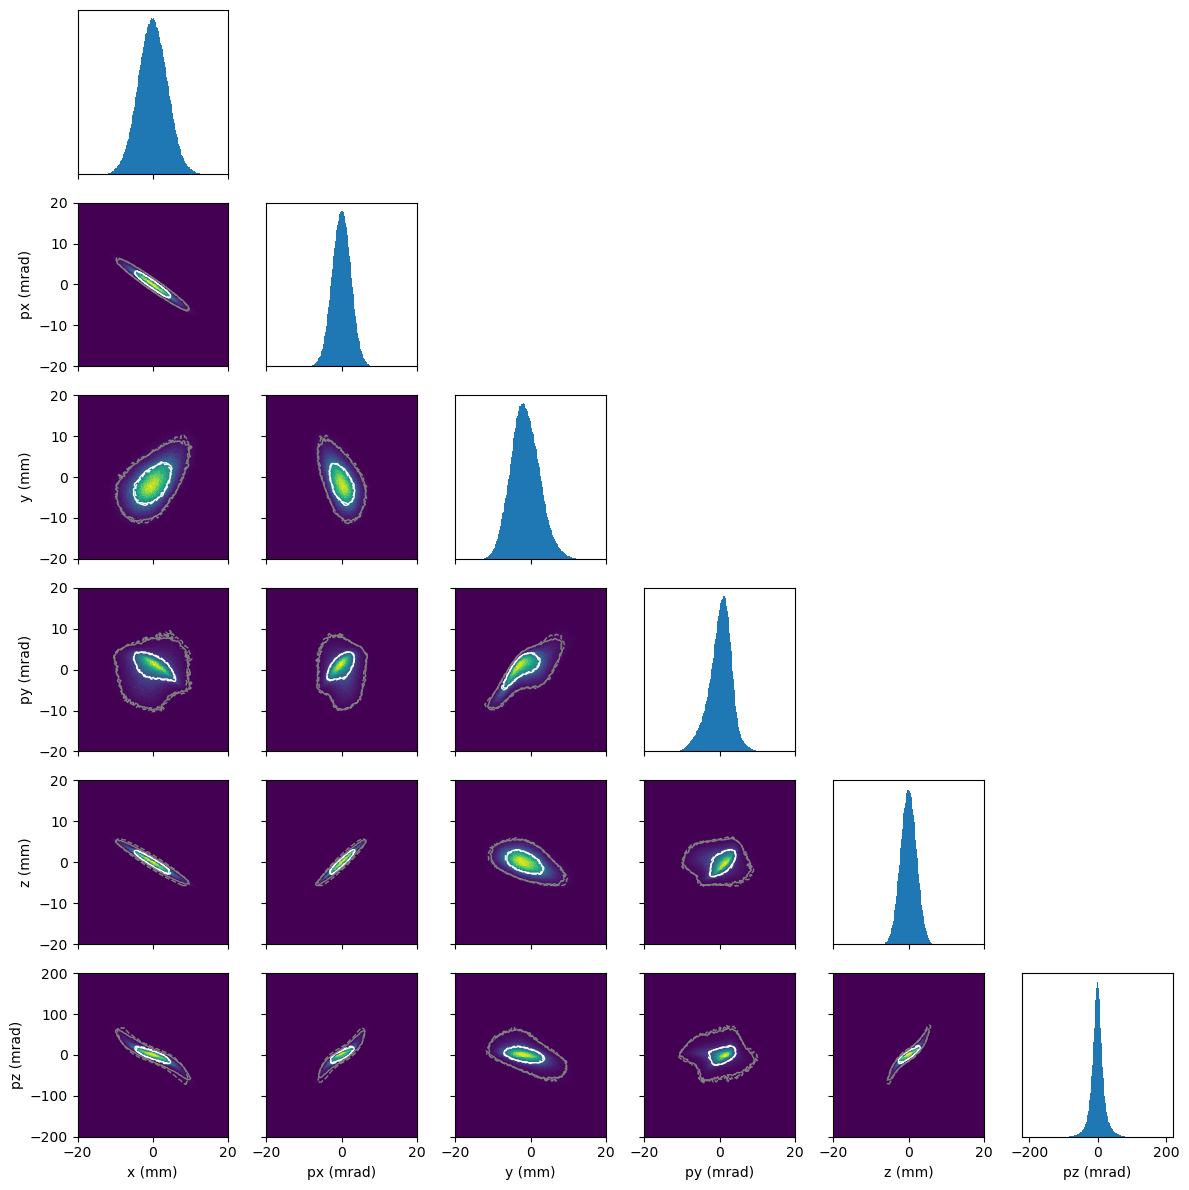

In [25]:
plot_projections_with_contours(
    r_1e6,
    gt,
    bins=200,
    contour_percentiles = [50, 95],
    custom_lims=lims,
    contour_smoothing=0.5
)
plt.show()

In [10]:
levels = np.linspace(1,100,100)
levels

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])

In [11]:
np.where(a>4, 1, 0)

NameError: name 'a' is not defined

In [ ]:
plt.close()
reconstructions = [r_1e4, r_1e5, r_1e6]
for reconstruction in reconstructions:
    fig, ax = plot_projections_with_contours(
        reconstruction,
        gt,
        bins=200,
        contour_percentiles = [5, 50, 95],
        custom_lims=lims,
        contour_smoothing=0.001
    )
    plt.show()

# 3D scan vs 'T' scan

In [ ]:
gt_2 = torch.load(os.path.join(t_scan_dir, 'non_gaussian_beam.pt')).numpy_particles()
r_3d = torch.load(os.path.join(t_scan_dir, '3D_scan_100_000.pt')).numpy_particles()
r_t = torch.load(os.path.join(t_scan_dir, 't_scan_100_000.pt')).numpy_particles()

In [ ]:
# plot ground truth beam:
plot_projections(gt_2, custom_lims=lims)
plt.show()

In [ ]:
# plot 3d scan reconstructed beam
plot_projections(r_3d, custom_lims=lims)
plt.show()

In [ ]:
# plot t scan reconstructed beam
plot_projections(r_t, custom_lims=lims)
plt.show()

In [ ]:
reconstructions_2 = [r_3d, r_t]
for reconstruction in reconstructions_2:
    fig, ax = plot_projections_with_contours(
        reconstruction,
        gt_2,
        bins=200,
        contour_percentiles = [50, 95],
        contour_smoothing = 2,
        custom_lims=lims,

    )
    plt.show()

In [ ]:
a = np.array([
    [1,2],
    [3,4],
    [5,6]
])

In [ ]:
a[[0,1]]

In [ ]:
a[:,0]

In [ ]:
np.stack((a,a))

In [ ]:
getattr(b,'x')

In [ ]:
b.get_attribute(1)

In [ ]:
np.linspace(100, 1, 100)